In [1]:
"""
In this notebook, i took a sample from internet and changed it 
to a simple problem.
I generate random string and give a label according to most occuring letter
in sequence.
"""

from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn
import torch.optim as optim

In [2]:
"""
A utility class to log all the sub steps of a
pytorch calculation.
Usage is sending data with label.
If data send is torch tensor, 
"""
class StepLogger():
    def __init__(self,capacity):
        self.tensor_datas = {}        
        self.capacity = capacity
        self.added_labels = []
        
    
    def add_info(self,tensor_data,tensor_label):
        if tensor_label not in self.added_labels:
            self.added_labels.append( tensor_label )
        
        if tensor_label in self.tensor_datas.keys():
            current_arr = self.tensor_datas.get(tensor_label)
            if len(current_arr) < self.capacity:
                current_arr = self.tensor_datas.get(tensor_label, [])
                current_arr.append(tensor_data)
        else:
            self.tensor_datas[tensor_label] = [tensor_data]
    
    def get_default_summary(self,show_data=False,summary_count=1):
        self.get_summary(self.added_labels,show_data)
        
    def get_summary(self,labels,show_data=False,summary_count=1):
        count = 0
        for i in range(summary_count):
            for l in labels:
                label_data = self.tensor_datas.get(l)[count]
                print(l)
                if torch.is_tensor(label_data):
                    print( list(label_data.size() ) )
                if not show_data and not torch.is_tensor(label_data):
                    print(label_data)
                if show_data:    
                    print(label_data)
        
            
step =  StepLogger(2)
step.add_info(1,"a")
print(step.tensor_datas)
step.add_info(2,"a")
print(step.tensor_datas)
step.add_info(3,"a")
print(step.tensor_datas)

step.add_info(3,"b")
step.add_info(4,"b")
print(step.tensor_datas)
        
step.get_summary(["a","b"])
step.get_default_summary()

{'a': [1]}
{'a': [1, 2]}
{'a': [1, 2]}
{'a': [1, 2], 'b': [3, 4]}
a
1
b
3
a
1
b
3


In [3]:
a = torch.randn(1, 2)
c = torch.randn(2, 1)
step =  StepLogger(2)
for i in range(3):
    step.add_info(a,"a")
    
for i in range(3):
    step.add_info(c,"c")   

step.get_summary(["a","c"],2)    
#print(step.tensor_datas)
step.get_default_summary(False)

a
[1, 2]
tensor([[-1.4496,  0.6655]])
c
[2, 1]
tensor([[ 0.8003],
        [-0.9717]])
a
[1, 2]
c
[2, 1]


In [4]:
n_letters = 20
all_letters = "abcdefghijklmnoprstuvyz"

def sequence_convert(name):
    rep = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep


def gen_data_tuple():
    seq_len = random.randint(1,5) + 5
    sequence = [ random.randint(1,19) for _ in range(seq_len)]
    b = {}
    for item in sequence:
        #only count smaller than 10
        if item < 10:
            b[item] = b.get(item, 0) + 1    
    sb = sorted(b.items(), key=lambda x: x[1],reverse=True)   
    most_occur = 1
    try:
        most_occur = sb[0][0]
    except:
        #print("sb ",sb)
        most_occur = 1
        sequence += sequence + [1,2,3,1]
        
    
    result_list = sequence+[most_occur]
    result_list = random.sample(result_list,len(result_list))
    to_word = [all_letters[i-1] for i in result_list ]
    return to_word,[all_letters[most_occur-1] ]

def nat_rep(data_index):
    return torch.tensor([all_letters.index(data_index[0])], dtype = torch.long)

d = gen_data_tuple()
print(d)
nat_rep(d[1])
#seq_rep(d[0])


(['f', 'i', 'i', 'o', 's', 'i', 'i'], ['i'])


tensor([8])

In [5]:
trains = [ gen_data_tuple() for _ in range(1000)]
X_train = [t[0] for t in trains ]
y_train = [t[1] for t in trains ]

tests = [ gen_data_tuple() for _ in range(200)]
X_test = [t[0] for t in tests ]
y_test = [t[1] for t in tests ]

In [6]:
trains[0][1][0]


'h'

In [7]:
count = {}
for l in all_letters:
    count[l] = 0

for d in trains:
    count[d[1][0]] += 1


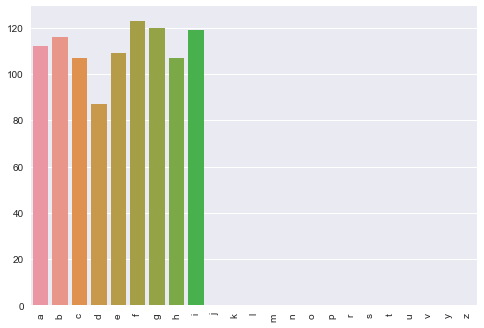

In [8]:
#plot the distribution
plt.style.use("seaborn")
plt_ = sns.barplot(list(count.keys()), list(count.values()))
plt_.set_xticklabels(plt_.get_xticklabels(), rotation = 90)
plt.show()

In [9]:
def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_train, y_train)
    
    step_logger.add_info(len(data_),"train data length")
    for name, language, name_ohe, lang_rep in data_:
            
        hidden = net.init_hidden()
        step_logger.add_info(name,"train name")
        step_logger.add_info(language,"train language")
        
        step_logger.add_info(name_ohe,"train input_sequence")
        for i in range(name_ohe.size()[0]):
            name_ohetens = name_ohe[i]
            step_logger.add_info(name_ohetens,"train input_sequence element")
            output, hidden = net(name_ohetens, hidden)
            
        step_logger.add_info(output,"train output of input_sequence  process")
        step_logger.add_info(lang_rep,"train actual label")
        
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
            
    return total_loss/n_points

In [10]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq = 5):

    criterion = nn.NLLLoss() #define a loss function
    opt = optim.SGD(net.parameters(), lr = lr, momentum = momentum) #define a optimizer
    loss_arr = np.zeros(n_batches + 1)

    #iterate through all the batches
    for i in range(n_batches):
        loss_arr[i + 1] = (loss_arr[i]*i + train(net, opt, criterion, batch_size))/(i + 1)

        if i%display_freq == display_freq - 1:
            #clear_output(wait = True)

            print("Iteration number ", i + 1, "Top - 1 Accuracy:", round(eval(net, len(X_test), 1, X_test, y_test),4), 
                  'Top-2 Accuracy:', round(eval(net, len(X_test), 2, X_test, y_test),4), 'Loss:', round(loss_arr[i],4))
            plt.figure()
            plt.plot(loss_arr[1:i], "-*")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.show()
            print("\n\n")
    return loss_arr        

In [11]:
#create a dataloader

def dataloader(npoints, X_, y_):
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_] #get the data at the random index
        to_ret.append((name, lang, sequence_convert(name), nat_rep(lang)))

    return to_ret

In [12]:
#create a function to evaluate model

def eval(net, n_points, k, X_, y_):
     data_ = dataloader(n_points, X_, y_)
     correct = 0

     for name, language, name_ohe, lang_rep in data_:
         output = infer(net, name) #prediction
         val, indices = output.topk(k) #get the top k predictions
         try:
            if lang_rep in torch.flatten(indices):
                correct += 1
                step_logger.add_info(lang_rep,"eval correct lang_rep")
                step_logger.add_info(indices,"eval correct indices")
            else:
                step_logger.add_info(lang_rep,"eval false lang_rep")
                step_logger.add_info(indices,"eval false indices")
            
         except:
            print("false lang_rep ",lang_rep," indices ",indices)
            
                        
    
     accuracy = correct/n_points
     return accuracy

#function to make inference

def infer(net, name):
    net.eval()
    name_ohe = sequence_convert(name)
    hidden = net.init_hidden()

    for i in range(name_ohe.size()[0]):
        output, hidden = net(name_ohe[i], hidden)

    return output

In [13]:

        
        
class LSTM_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_net, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTM(input_size, hidden_size) #LSTM cell
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 2)

    def forward(self, input_, hidden):
        step_logger.add_info(input_,"forward input")
        out, hidden = self.lstm_cell(input_.view(1, 1, -1), hidden)
        step_logger.add_info(hidden[0],"forward hidden0")
        step_logger.add_info(hidden[1],"forward hidden1")
        step_logger.add_info(out,"forward out")
        
        output = self.h2o(hidden[0])
        step_logger.add_info(output,"forward h20")
        
        output = self.softmax(output)
        step_logger.add_info(output,"forward softmax")
        
        return output.view(1, -1), hidden

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

Iteration number  5 Top - 1 Accuracy: 0.065 Top-2 Accuracy: 0.21 Loss: 2.3543


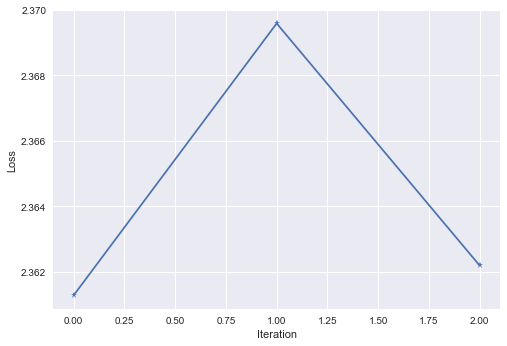




Iteration number  10 Top - 1 Accuracy: 0.215 Top-2 Accuracy: 0.29 Loss: 2.3265


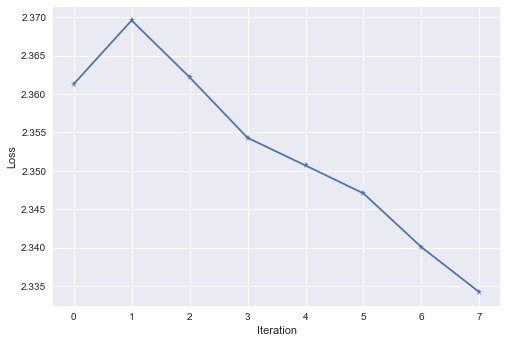




Iteration number  15 Top - 1 Accuracy: 0.15 Top-2 Accuracy: 0.345 Loss: 2.2944


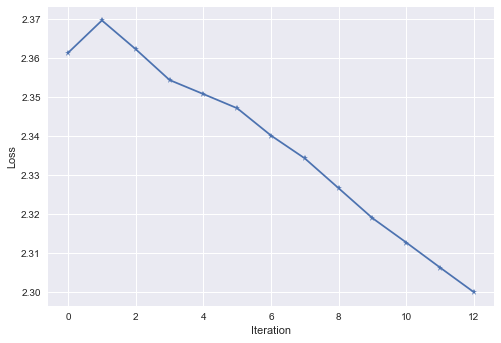




Iteration number  20 Top - 1 Accuracy: 0.145 Top-2 Accuracy: 0.265 Loss: 2.2718


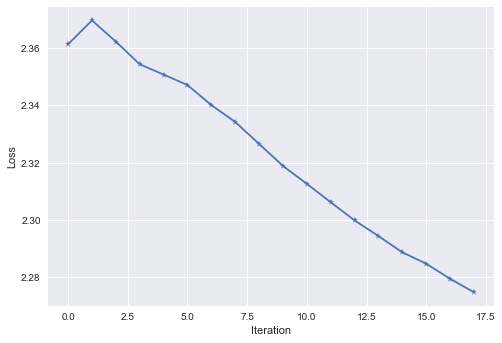




Iteration number  25 Top - 1 Accuracy: 0.145 Top-2 Accuracy: 0.245 Loss: 2.2544


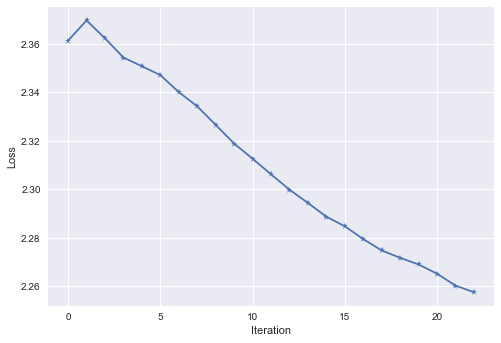




Iteration number  30 Top - 1 Accuracy: 0.185 Top-2 Accuracy: 0.285 Loss: 2.2416


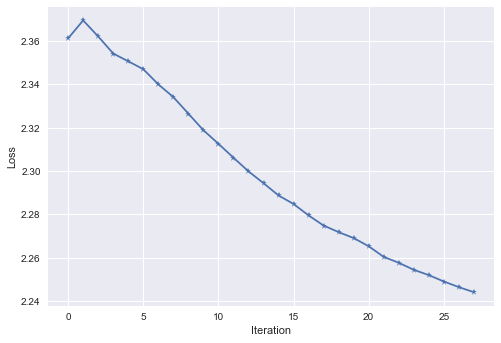




Iteration number  35 Top - 1 Accuracy: 0.195 Top-2 Accuracy: 0.31 Loss: 2.229


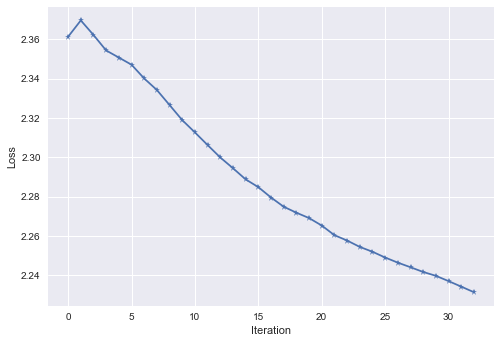




Iteration number  40 Top - 1 Accuracy: 0.2 Top-2 Accuracy: 0.41 Loss: 2.216


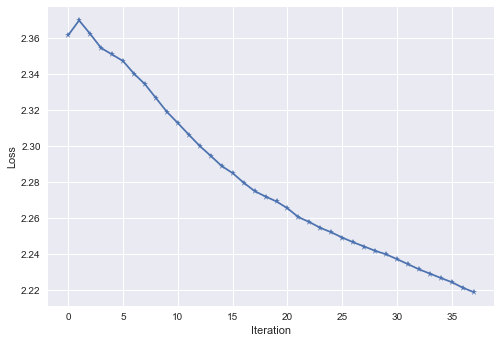




Iteration number  45 Top - 1 Accuracy: 0.205 Top-2 Accuracy: 0.495 Loss: 2.1997


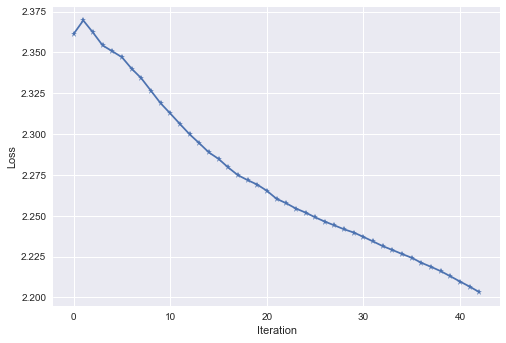




Iteration number  50 Top - 1 Accuracy: 0.165 Top-2 Accuracy: 0.395 Loss: 2.1776


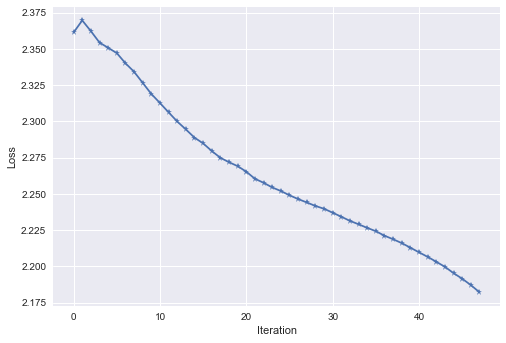




Iteration number  55 Top - 1 Accuracy: 0.235 Top-2 Accuracy: 0.47 Loss: 2.1566


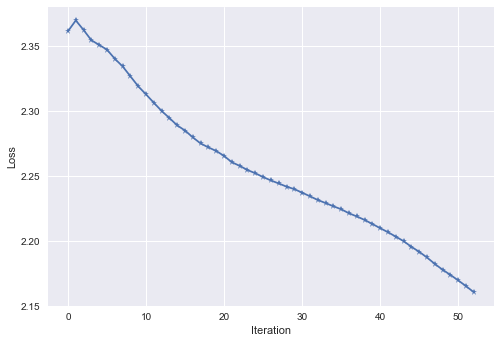




Iteration number  60 Top - 1 Accuracy: 0.175 Top-2 Accuracy: 0.365 Loss: 2.1349


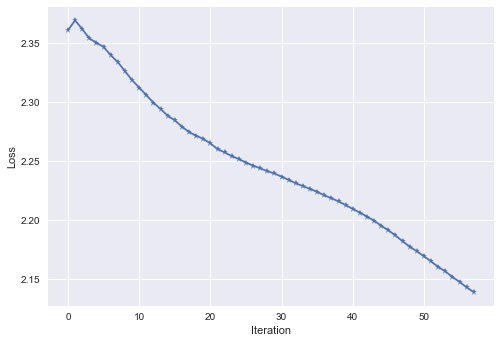




Iteration number  65 Top - 1 Accuracy: 0.315 Top-2 Accuracy: 0.52 Loss: 2.1088


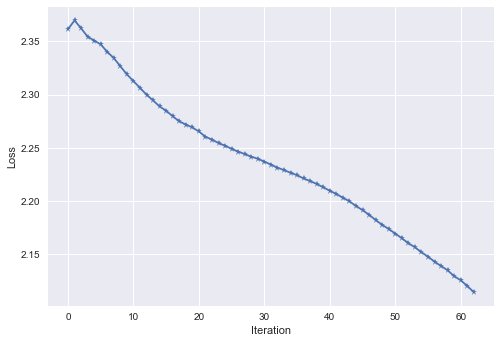




Iteration number  70 Top - 1 Accuracy: 0.335 Top-2 Accuracy: 0.55 Loss: 2.0817


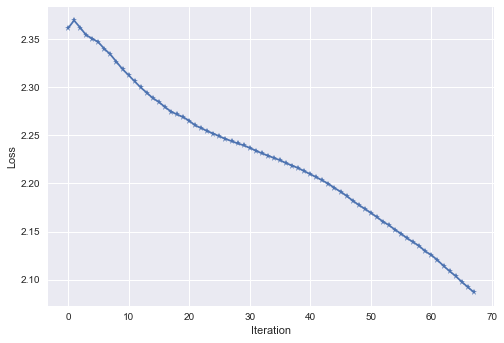




Iteration number  75 Top - 1 Accuracy: 0.41 Top-2 Accuracy: 0.61 Loss: 2.0466


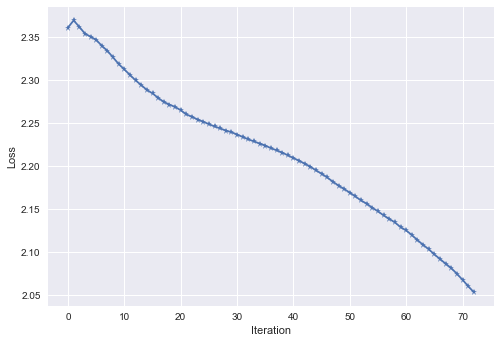




Iteration number  80 Top - 1 Accuracy: 0.505 Top-2 Accuracy: 0.745 Loss: 2.0084


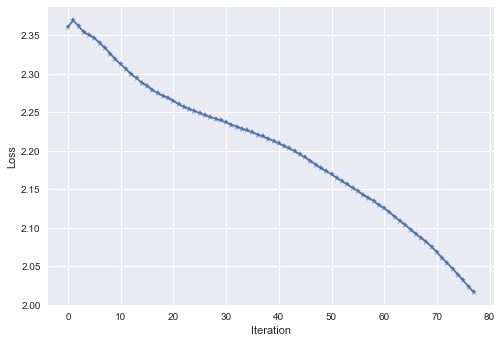




Iteration number  85 Top - 1 Accuracy: 0.48 Top-2 Accuracy: 0.695 Loss: 1.9736


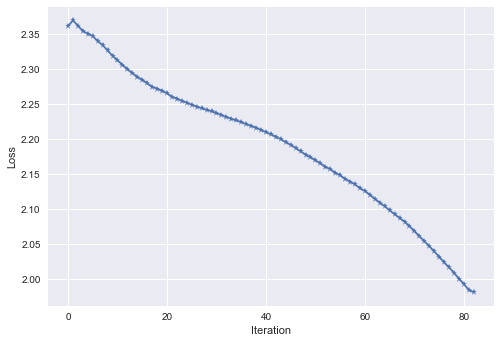




Iteration number  90 Top - 1 Accuracy: 0.505 Top-2 Accuracy: 0.785 Loss: 1.9332


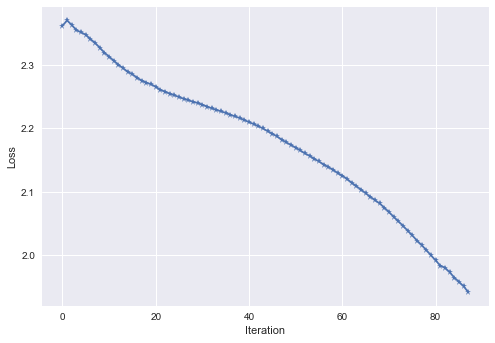




Iteration number  95 Top - 1 Accuracy: 0.56 Top-2 Accuracy: 0.83 Loss: 1.8899


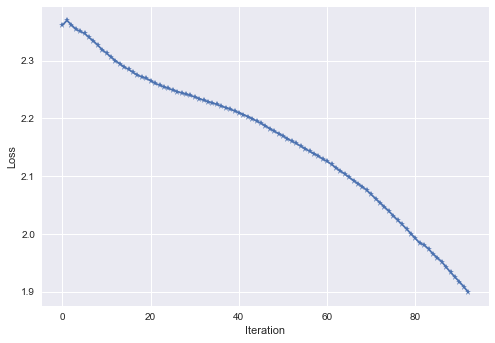




Iteration number  100 Top - 1 Accuracy: 0.74 Top-2 Accuracy: 0.895 Loss: 1.8414


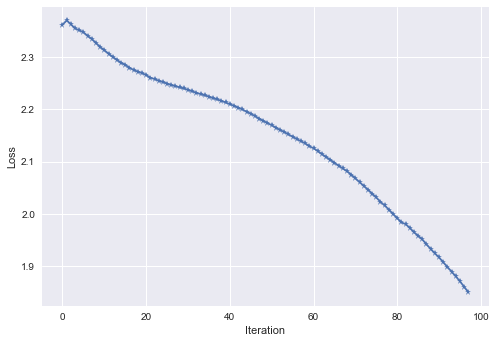




Iteration number  105 Top - 1 Accuracy: 0.705 Top-2 Accuracy: 0.91 Loss: 1.7891


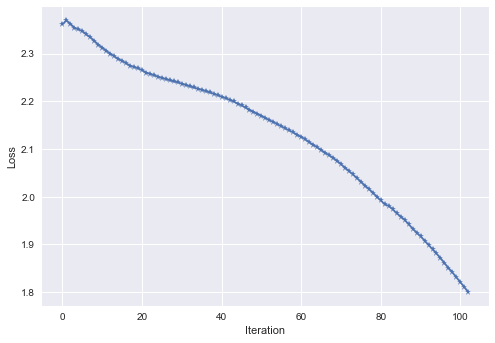




Iteration number  110 Top - 1 Accuracy: 0.785 Top-2 Accuracy: 0.935 Loss: 1.7358


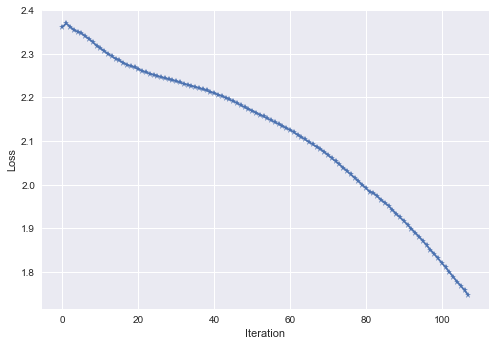




Iteration number  115 Top - 1 Accuracy: 0.725 Top-2 Accuracy: 0.88 Loss: 1.6799


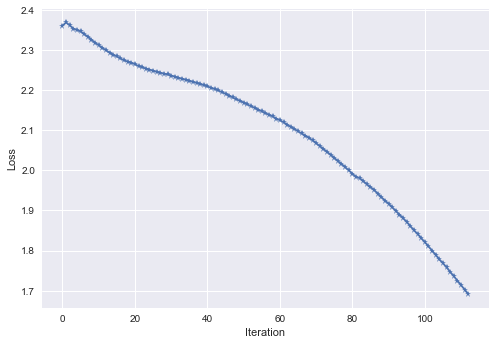




Iteration number  120 Top - 1 Accuracy: 0.8 Top-2 Accuracy: 0.93 Loss: 1.6262


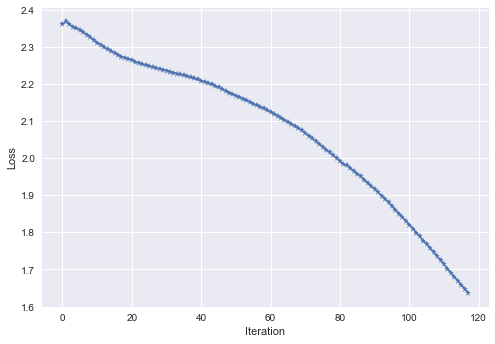




Iteration number  125 Top - 1 Accuracy: 0.835 Top-2 Accuracy: 0.965 Loss: 1.5754


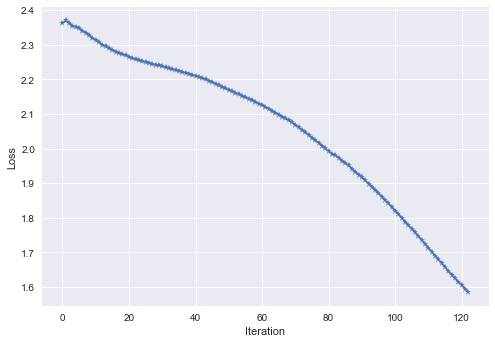




Iteration number  130 Top - 1 Accuracy: 0.805 Top-2 Accuracy: 0.93 Loss: 1.5262


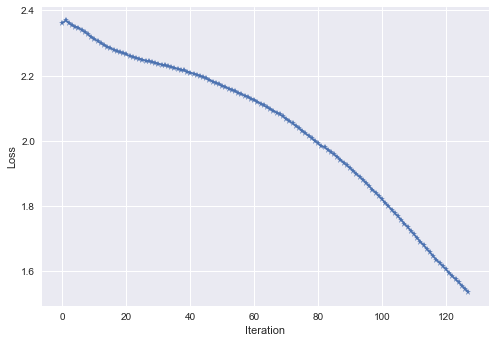




Iteration number  135 Top - 1 Accuracy: 0.805 Top-2 Accuracy: 0.955 Loss: 1.4797


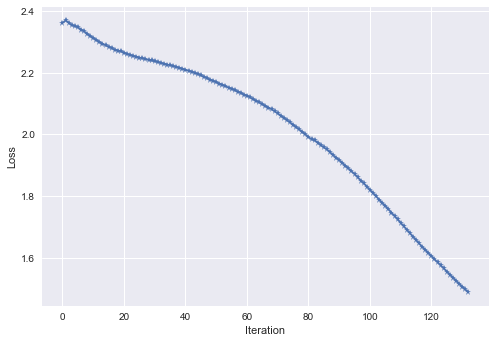




Iteration number  140 Top - 1 Accuracy: 0.86 Top-2 Accuracy: 0.965 Loss: 1.4369


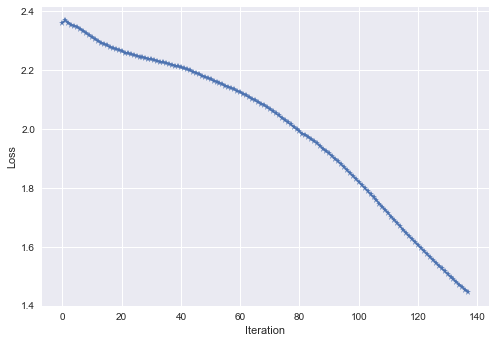




Iteration number  145 Top - 1 Accuracy: 0.805 Top-2 Accuracy: 0.98 Loss: 1.3961


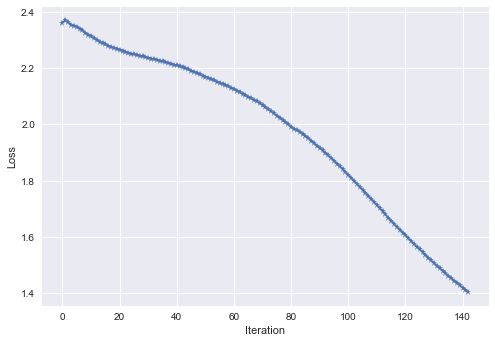




Iteration number  150 Top - 1 Accuracy: 0.825 Top-2 Accuracy: 0.95 Loss: 1.3573


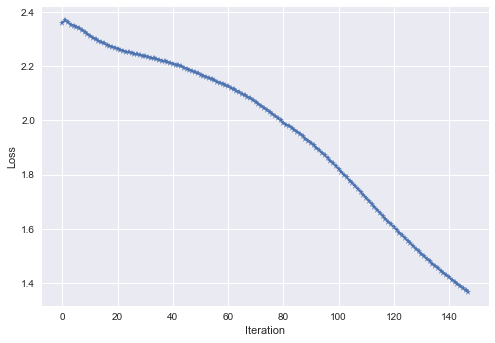




Iteration number  155 Top - 1 Accuracy: 0.91 Top-2 Accuracy: 0.955 Loss: 1.3222


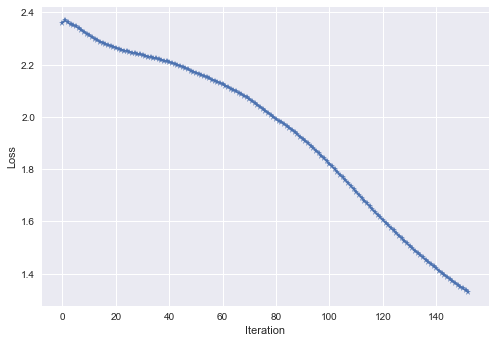




Iteration number  160 Top - 1 Accuracy: 0.84 Top-2 Accuracy: 0.995 Loss: 1.288


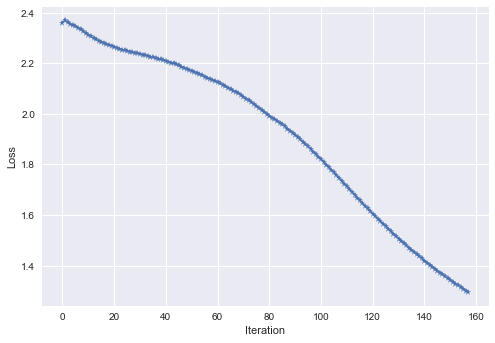




Iteration number  165 Top - 1 Accuracy: 0.905 Top-2 Accuracy: 0.95 Loss: 1.2546


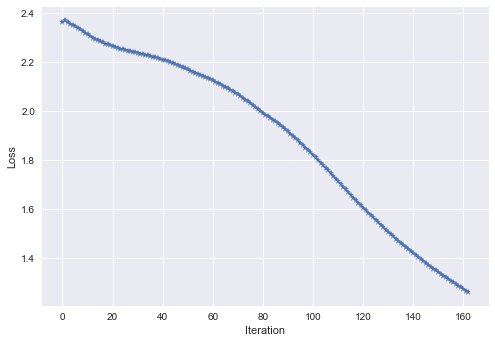




Iteration number  170 Top - 1 Accuracy: 0.785 Top-2 Accuracy: 0.985 Loss: 1.2227


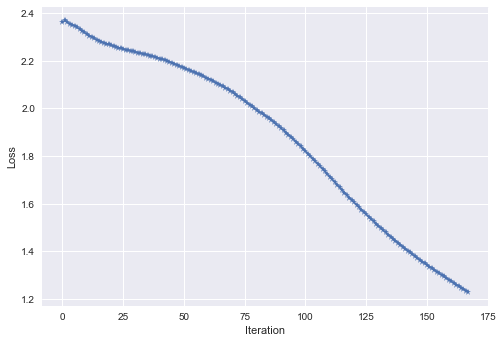




Iteration number  175 Top - 1 Accuracy: 0.8 Top-2 Accuracy: 0.985 Loss: 1.1929


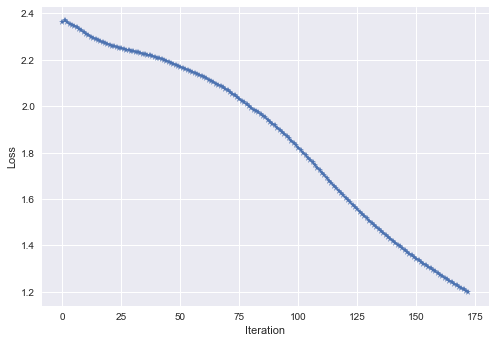




Iteration number  180 Top - 1 Accuracy: 0.825 Top-2 Accuracy: 0.98 Loss: 1.165


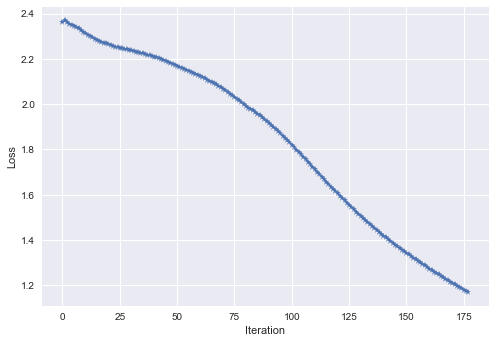




Iteration number  185 Top - 1 Accuracy: 0.935 Top-2 Accuracy: 1.0 Loss: 1.1376


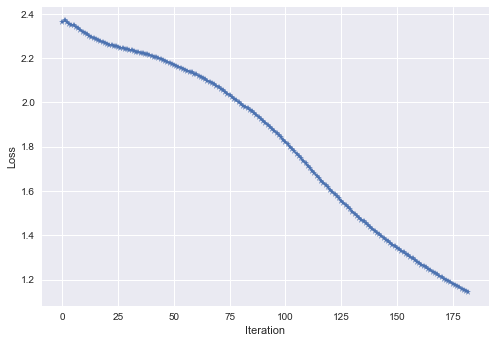




Iteration number  190 Top - 1 Accuracy: 0.885 Top-2 Accuracy: 0.99 Loss: 1.1121


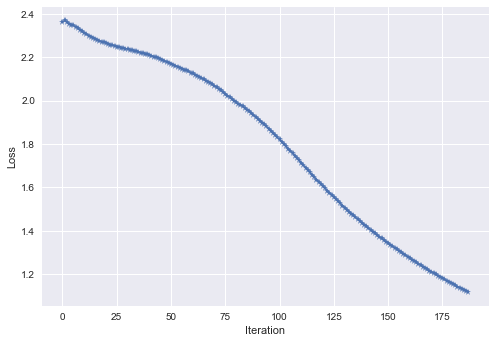




Iteration number  195 Top - 1 Accuracy: 0.84 Top-2 Accuracy: 0.96 Loss: 1.0878


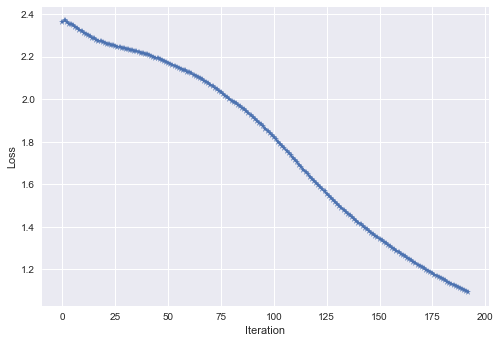




Iteration number  200 Top - 1 Accuracy: 0.875 Top-2 Accuracy: 0.995 Loss: 1.064


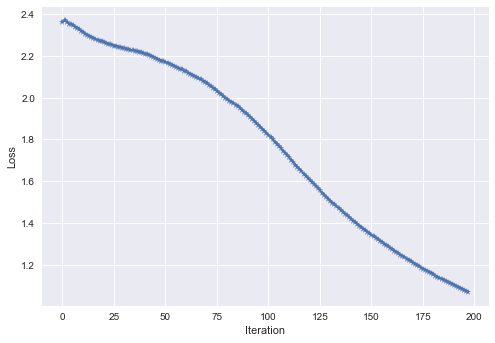

In [14]:
step_logger =  StepLogger(2)

n_hidden = 9
n_languages = 10
n_letters = 20
net = LSTM_net(n_letters, n_hidden, n_languages)
loss_arr = train_setup(net, lr = 0.0005, n_batches = 200, batch_size = 256)

In [15]:
print("Top - 1 Accuracy:", round(eval(net, len(X_test), 1, X_test, y_test),4))
print('Top-2 Accuracy:', round(eval(net, len(X_test), 2, X_test, y_test),4))

Top - 1 Accuracy: 0.885
Top-2 Accuracy: 0.985


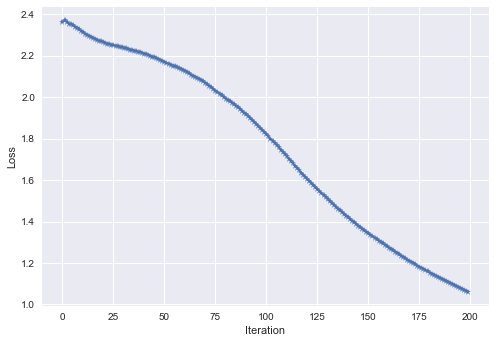

In [16]:
plt.figure()
plt.plot(loss_arr[1:], "-*")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()
print("\n\n")


In [17]:
step_logger.get_default_summary(False)

train data length
256
train name
['n', 'h', 'h', 'l', 'h', 'm', 'i']
train language
['h']
train input_sequence
[7, 1, 20]
train input_sequence element
[1, 20]
forward input
[1, 20]
forward hidden0
[1, 1, 9]
forward hidden1
[1, 1, 9]
forward out
[1, 1, 9]
forward h20
[1, 1, 10]
forward softmax
[1, 1, 10]
train output of input_sequence  process
[1, 10]
train actual label
[1]
eval false lang_rep
[1]
eval false indices
[1, 1]
eval correct lang_rep
[1]
eval correct indices
[1, 1]


In [18]:
step_logger.get_default_summary(True)

train data length
256
train name
['n', 'h', 'h', 'l', 'h', 'm', 'i']
train language
['h']
train input_sequence
[7, 1, 20]
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.]]])
train input_sequence element
[1, 20]
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0.]])
forward input
[1, 20